<a href="https://colab.research.google.com/github/MStamirski/Optic-sensors/blob/main/Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# functions

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pd.options.display.float_format = '{:.9f}'.format

In [4]:
def get_filenames():
  substances = ["air", "water", "izopropanol"]
  sensor_nbrs = [str(sens).zfill(2) for sens in range(1,11)]
  filenames = []
  for sensor in sensor_nbrs:
    for substance in substances:
      filename = "sensor"+sensor+"_"+substance
      filenames.append(filename)
  return filenames

In [5]:
def get_sensor_data(filename):
  records = []
  path = "drive/MyDrive/Colab_Notebooks/SDA_Upskill/data/"
  
  with open(path+filename+".txt") as file:
    for data in file:
      record = data.strip().split(',')
      records.append(record)
  
  df = pd.DataFrame.from_records(records,columns=['wavelength', 'amplitude'])
  df['wavelength'] = df['wavelength'].astype('float')
  df['amplitude'] = df['amplitude'].astype('float')

  return df

In [6]:
def show_data(filename):
  df = get_sensor_data(filename)
  print(f"\n------------ {filename} ----------")
  print(f"Observations: \n{df.count()}")
  print(f"Unique wavelengths: {len(df['wavelength'].unique())}")
  print(f"NULLS: \n{df.isna().sum()}")
  print(f"MAX: \n{df.max()}")
  print(f"MIN: \n{df.min()}")

In [7]:
def plot_sensors_data():
  dframes = []
  filenames = get_filenames()
  for filename in filenames:
    df = get_sensor_data(filename)
    dframes.append(df)

  fig, axs = plt.subplots(2,5, figsize=(25,10))
  for i, ax in enumerate(fig.axes):
    ax.set_title("Sensor"+str(i+1).zfill(2))
    ax.plot(dframes[i*3]['wavelength'], dframes[i*3]['amplitude'], label = "air", color = "r")
    ax.plot(dframes[i*3+1]['wavelength'], dframes[i*3+1]['amplitude'], label = "water", color = "b")
    ax.plot(dframes[i*3+2]['wavelength'], dframes[i*3+2]['amplitude'], label = "izopropanol", color = "g")
    ax.legend(loc = "upper center")
    
  fig.show()

In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

In [9]:
scaler_w = MinMaxScaler()
scaler_i = MinMaxScaler()

In [10]:
model_w = MLPRegressor(
  hidden_layer_sizes=(32, 16, 8, 4),
  activation='tanh',
  solver='adam',
  random_state=42,
  max_iter=300,
  batch_size=60)

model_i = MLPRegressor(
  hidden_layer_sizes=(32, 16, 8, 4),
  activation='tanh',
  solver='adam',
  random_state=42,
  max_iter=300,
  batch_size=60)

In [11]:
def train_water_model(df):
  X = df[df.columns[:2]]
  y = df[df.columns[2]]

  X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

  X_train_sc = scaler_w.fit_transform(X_train)
  X_val_sc = scaler_w.transform(X_val)
  
  model_w.fit(X_train_sc, y_train)

  return X_val_sc, y_val

In [12]:
def train_izop_model(df):
  X = df[df.columns[:2]]
  y = df[df.columns[2]]

  X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

  X_train_sc = scaler_i.fit_transform(X_train)
  X_val_sc = scaler_i.transform(X_val)
  
  model_i.fit(X_train_sc, y_train)

  return X_val_sc, y_val

In [13]:
def make_water_prediction(X_val_sc, y_val):
  y_pred = model_w.predict(X_val_sc)

  print("METRICS FOR VALIDATION DATASET:")
  print(f"MAE OF PREDICTION  : {round(mean_absolute_error(y_val, y_pred),4)}")
  print(f"MAPE OF PREDICTION : {round(mean_absolute_percentage_error(y_val, y_pred),4)}")
  print("\n")

In [14]:
def make_izop_prediction(X_val_sc, y_val):
  y_pred = model_i.predict(X_val_sc)

  print("METRICS FOR VALIDATION DATASET:")
  print(f"MAE OF PREDICTION  : {round(mean_absolute_error(y_val, y_pred),4)}")
  print(f"MAPE OF PREDICTION : {round(mean_absolute_percentage_error(y_val, y_pred),4)}")
  print("\n")

In [27]:
def plot_water_test():

  print("TESTING MODEL ON REMAINING SENSORS\n")

  sensor_nbrs = [str(sens).zfill(2) for sens in range(8,11)]
  filenames_a = []
  filenames_w = []
  for sensor in sensor_nbrs:
    filename_a = "sensor"+sensor+"_air"
    filenames_a.append(filename_a)
    filename_w = "sensor"+sensor+"_water"
    filenames_w.append(filename_w)
  
  dframes_a = []
  for filename in filenames_a:
    df = get_sensor_data(filename)
    df.columns = ['X1', 'X2']
    dframes_a.append(df)

  dframes_w = []
  for filename in filenames_w:
    df = get_sensor_data(filename)
    df.columns = ['X1', 'X2']
    dframes_w.append(df)

  fig, axs = plt.subplots(1,3, figsize=(15,5))
  for i, ax in enumerate(fig.axes):

    A = dframes_a[i]
    A_sc = scaler_w.transform(A)
    y_pred = model_w.predict(A_sc) 
    mae = round(mean_absolute_error(dframes_w[i]['X2'], y_pred),4)
    mape = round(mean_absolute_percentage_error(dframes_w[i]['X2'], y_pred),4)

    ax.set_title("Water, sensor"+str(i+8).zfill(2)+", MAE: "+str(mae)+", MAPE: "+str(mape))
    ax.plot(dframes_w[i]['X1'], dframes_w[i]['X2'], label = "ground truth", color = "r")
    ax.plot(A['X1'], y_pred, label = "prediction", color = "b")

    ax.legend(loc = "upper center")

  fig.show()

In [16]:
def plot_izop_test():

  print("TESTING MODEL ON REMAINING SENSORS\n")

  sensor_nbrs = [str(sens).zfill(2) for sens in range(8,11)]
  filenames_a = []
  filenames_i = []
  for sensor in sensor_nbrs:
    filename_a = "sensor"+sensor+"_air"
    filenames_a.append(filename_a)
    filename_i = "sensor"+sensor+"_izopropanol"
    filenames_i.append(filename_i)
  
  dframes_a = []
  for filename in filenames_a:
    df = get_sensor_data(filename)
    df.columns = ['X1', 'X2']
    dframes_a.append(df)

  dframes_i = []
  for filename in filenames_i:
    df = get_sensor_data(filename)
    df.columns = ['X1', 'X2']
    dframes_i.append(df)

  fig, axs = plt.subplots(1,3, figsize=(15,5))
  for i, ax in enumerate(fig.axes):

    A = dframes_a[i]
    A_sc = scaler_i.transform(A)
    y_pred = model_i.predict(A_sc) 
    mae = round(mean_absolute_error(dframes_i[i]['X2'], y_pred),4)
    mape = round(mean_absolute_percentage_error(dframes_i[i]['X2'], y_pred),4)

    ax.set_title("Izoprop., sensor"+str(i+8).zfill(2)+", MAE: "+str(mae)+", MAPE: "+str(mape))
    ax.plot(dframes_i[i]['X1'], dframes_i[i]['X2'], label = "ground truth", color = "r")
    ax.plot(A['X1'], y_pred, label = "prediction", color = "b")

    ax.legend(loc = "upper center")

  fig.show()

In [17]:
def test_water_model(df):
  X_val_sc, y_val = train_water_model(df)
  make_water_prediction(X_val_sc, y_val)
  plot_water_test()

In [18]:
def test_izop_model(df):
  X_val_sc, y_val = train_izop_model(df)
  make_izop_prediction(X_val_sc, y_val)
  plot_izop_test()

# Demonstration of concept

**Business and goal of the project**

A company produces fiber optic sensors. After the production, a characteristic of each sensor should be verified in three substances: air, water, izopropanol. In result the laboratory collects data of three signals. Each of them is two dimensional and shows dependence between wavelength and amplitude of the signal.

This procedure is expensive. The company wants to reduce validation process only to measurement in the air. The chacteristics of signals in remaining  substances would be predicted on this basis.

The goal of the project is to deliver a machine learning model, which would accomplish this task.

**Data**

We have data of 10 sensors, validated in 3 substances. Each validation consists of 3001 measurements. Description of one of these 30 datasets is shown in the table below. Remaining 29 datasets are similiar. The range of wavelength is the same, all wavelengths are unique, number of observations is the same, there is no nulls nor outliers. There are differences only in amplitudes.

In [19]:
show_data("sensor01_air")


------------ sensor01_air ----------
Observations: 
wavelength    3001
amplitude     3001
dtype: int64
Unique wavelengths: 3001
NULLS: 
wavelength    0
amplitude     0
dtype: int64
MAX: 
wavelength   0.000001650
amplitude    9.253300000
dtype: float64
MIN: 
wavelength    0.000001350
amplitude    -7.151200000
dtype: float64


Data for all 10 sensors and 3 substances are shown on diagrams below.

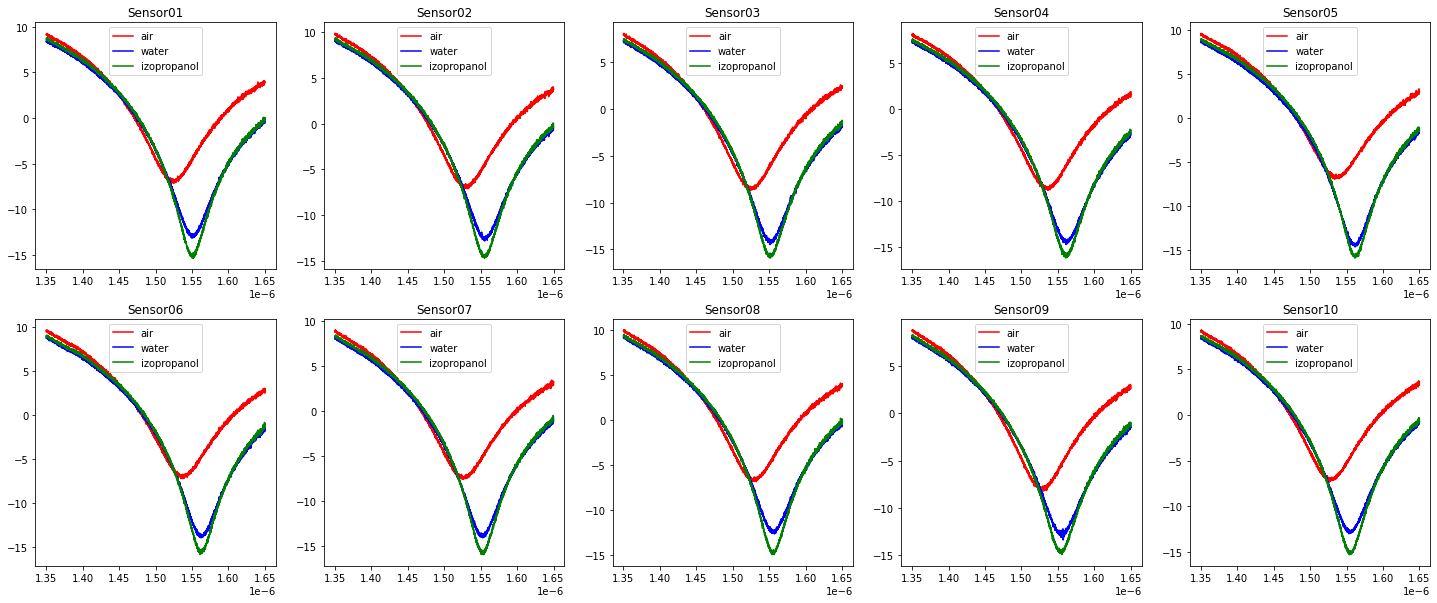

In [20]:
plot_sensors_data()

**The idea**

In proposed solution two separate models will be made: one for prediction of signal data in the water and second in the izopropanol. In both models  independent variables will be wavelength and amplitude in the air, and dependent variable will be amplitude in remaining substances, assigned to wavelengths in whole range of measurements.

# Implementation

**Datasets**

Two datasets were created for training and validating two models. They contain concatenated data from first 7 sensors. Independent variables in both are the same: wavelength and amplitude in air, now called X1 and X2. Dependent variables "y" are amplitudes of signal in water or izopropanol, resulting from given wavelength (X1). 

This is a sample of data in dataset for "water" prediction.

In [22]:
path = "drive/MyDrive/Colab_Notebooks/SDA_Upskill/"
df_water = pd.read_csv(path+"water.csv", sep="\t").iloc[:, 1:] # without index
df_water.sample(5)

,X1,X2,y
8630,0.000001613,0.053157000,-4.968300000
12976,0.000001447,3.766200000,3.354700000
18387,0.000001388,6.968100000,6.212800000
12322,0.000001382,8.076300000,7.357000000
1923,0.000001542,-5.684200000,-12.156000000


In [23]:
df_water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21007 entries, 0 to 21006
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      21007 non-null  float64
 1   X2      21007 non-null  float64
 2   y       21007 non-null  float64
dtypes: float64(3)
memory usage: 492.5 KB


And this is a sample of data in dataset for "izopropanol" prediction.

In [24]:
df_izopropanol = pd.read_csv(path+"izopropanol.csv", sep="\t").iloc[:, 1:] # without index
df_izopropanol.sample(5)

,X1,X2,y
7855,0.000001535,-7.903800000,-12.481000000
3154,0.000001365,9.009400000,8.543500000
14496,0.000001599,-0.328020000,-7.338500000
10843,0.000001534,-8.551600000,-9.752000000
10883,0.000001538,-8.591600000,-10.905000000


In [25]:
df_izopropanol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21007 entries, 0 to 21006
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      21007 non-null  float64
 1   X2      21007 non-null  float64
 2   y       21007 non-null  float64
dtypes: float64(3)
memory usage: 492.5 KB


**Models**

Three types of models were evaluated: 
* MLPRegressor from sklearn.neural_network library
* DecisionTreeRegressor from sklearn.tree library
* Sequential from keras library

For each of them parameters tuning was performed. Finally MLPRegressor was chosen for both predictions.

# Results

**"Water" prediction**

Mean Absolute Error of prediction of signal amplitude in water equals in selected model 0.24 db, which gives 0.09 of Mean Absolute Percentage Error. These values result from performing prediction on validation dataset, which was separated from training dataset, while both contained data of first 7 sensors.

Trained model was then used to make predictions for remaining 3 sensors in whole range of wavelength. Metrics of these tests and comparison to real values ("ground truth") are presented on the diagrams below.

METRICS FOR VALIDATION DATASET:
MAE OF PREDICTION  : 0.2441
MAPE OF PREDICTION : 0.0924


TESTING MODEL ON REMAINING SENSORS



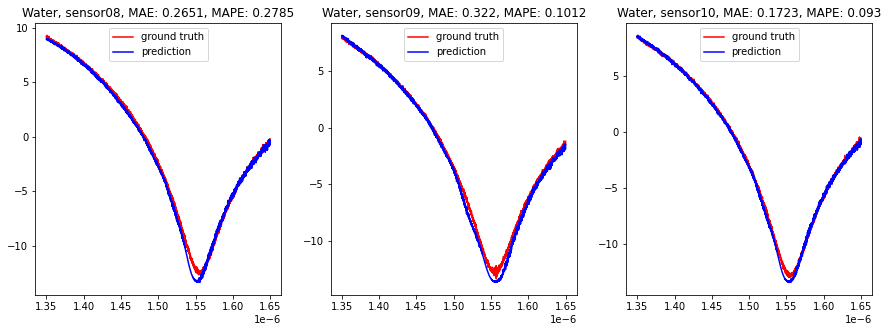

In [28]:
test_water_model(df_water)

**"Izopropanol" prediction**

Mean Absolute Error of prediction of signal amplitude in water equals in selected model 0.26 db, which gives 0.10 of Mean Absolute Percentage Error. These values result from performing prediction on validation dataset, which was separated from training dataset, while both contained data of first 7 sensors.

Trained model was then used to make predictions for remaining 3 sensors in whole range of wavelength. Metrics of these tests and comparison to real values ("ground truth") are presented on the diagrams below.

METRICS FOR VALIDATION DATASET:
MAE OF PREDICTION  : 0.2633
MAPE OF PREDICTION : 0.0955


TESTING MODEL ON REMAINING SENSORS



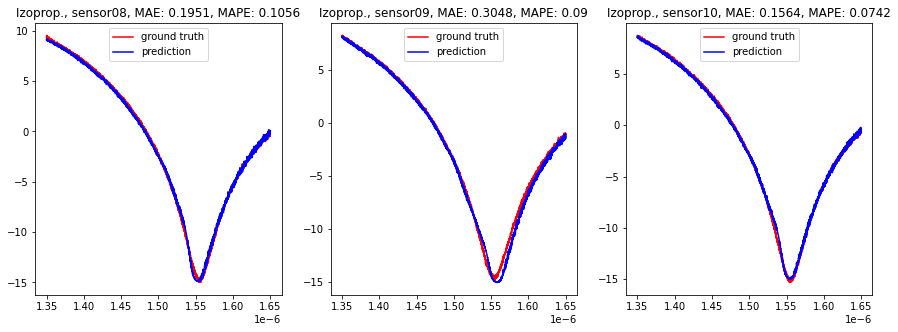

In [29]:
test_izop_model(df_izopropanol)

# Conclusion

**Summarizing, performance of created machine learning models appears to be quite attractive. Implementing them in the company could decrease significantly its costs. On the other hand, decision regarding deployment should take into consideration precision of sensors required in the industry. If errors of amplitude measurements may be grater than about 0,3 dB, this method would applicable.**